In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from dask.diagnostics import ProgressBar

In [3]:
cluster = SLURMCluster(queue='analysis', cores=4, project='gfdl_o',
                       memory="24GB", walltime="00:30:00",
                       scheduler_options={"dashboard_address": "localhost:8726"})

In [4]:
cluster.scale(2)
client = Client(cluster)
client

Client Scheduler: tcp://140.208.147.171:39964 Dashboard: http://140.208.147.171:8726/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Decadal variability of WMT in OM4 hincast

In [5]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xgcm import Grid
import glob
import wmt_bgc.basic as wmt
%matplotlib inline

In [6]:
# Specifications for heat and salt budgets
variables = {'heat':'thetao','salt':'so'}
processes=['boundary forcing','vertical diffusion','neutral diffusion',
           'frazil ice','internal heat']
terms = {}
terms['heat'] = {'boundary forcing':'boundary_forcing_heat_tendency',
         'vertical diffusion':'opottempdiff',
         'neutral diffusion':None,
         'frazil ice':'frazil_heat_tendency',
         'internal heat':None}
terms['salt'] = {'boundary forcing':'boundary_forcing_salt_tendency',
         'vertical diffusion':'osaltdiff',
         'neutral diffusion':None,
         'frazil ice':None,
         'internal heat':None}
# Additional variables to load
extra = {}
extra['surface'] = {'mass flux':'wfo'}
extra['full'] = {'volume':'volcello'}

In [7]:
# Load the data
config = 'OM4p25_JRA55do1.4_0netfw_cycle6'
rootdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'+config+'/gfdl.ncrc4-intel16-prod/pp/'
years = '2003*'

# 3D tendencies
pp = 'ocean_annual_z'
localdir = '/ts/annual/5yr/'
filenames = []
for variable in variables:
    filenames.append(glob.glob(rootdir+pp+localdir+pp+'.'+years+'.'+variables[variable]+'.nc'))
    for process in processes:
        term = terms[variable][process]
        if term is not None:
            filenames.append(glob.glob(rootdir+pp+localdir+pp+'.'+years+'.'+term+'.nc'))
# Additional 3D variables
term=extra['full']['volume']
filenames.append(glob.glob(rootdir+pp+localdir+pp+'.'+years+'.'+term+'.nc'))
ds = xr.open_mfdataset(filenames)

# Grid
grid = xr.open_dataset(rootdir+pp+'/'+pp+'.static.nc')

# gamma_n
gammadir = '/archive/gam/so_decadal_variability/OM4p25_JRA55do1.4_0netfw_cycle6/'
localdir = '/'
ds = xr.merge([ds,xr.open_mfdataset(gammadir+pp+localdir+pp+'.'+years+'.gamma_n.nc')['gamma_n']])
ds['gamma_n'] = ds['gamma_n'].where(ds['gamma_n']>0,np.nan)

# Surface fluxes
pp = 'ocean_monthly'
localdir = '/ts/monthly/5yr/'
term = extra['surface']['mass flux']
filenames = glob.glob(rootdir+pp+localdir+pp+'.'+years+'.'+term+'.nc')
ds_surf = xr.open_mfdataset(filenames)
# Take annual means of surface flux data
ds_surf_annual = ds_surf.groupby('time.year').mean('time').rename({'year':'time'}).assign_coords({'time':ds['time']})
# Expand surface flux variable to 3D, with zeros everywhere except surface 
ds_surf_annual = ds_surf_annual.expand_dims({'z_i':ds['z_i']}).where(ds['z_i']==ds['z_i'][0],0)

# Grab 
ds = xr.merge([ds,ds_surf_annual[term]])

# Specify some constants
Cp = 3992.
rho0 = 1035.

In [8]:
# Build an xgcm grid object
# Create a pseudo-grid in the vertical
grid['z_l'] = ds['z_l']
grid['z_i'] = ds['z_i']
grid['dzt'] = grid['z_l'].copy(data=grid['z_i'].diff('z_i'))
grid = grid.squeeze() # Get rid of any remnant time variables

# Fill in nans with zeros
grid['dxt'] = grid['dxt'].fillna(0.)
grid['dyt'] = grid['dyt'].fillna(0.)
grid['dzt'] = grid['dzt'].fillna(0.)
grid['areacello'] = grid['areacello'].fillna(0.)
grid['volcello'] = ds['volcello'].fillna(0.)
metrics = {
    ('X',): ['dxt','dxCu','dxCv'], # X distances
    ('Y',): ['dyt','dyCu','dyCv'], # Y distances
    ('Z',): ['dzt'], # Z distances
    ('X', 'Y'): ['areacello'], # Areas
    ('X', 'Y', 'Z'): ['volcello'], # Volumes
}
coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
        'Z': {'center': 'z_l', 'outer': 'z_i'} }
xgrid = Grid(grid, coords=coords, metrics=metrics, periodic=['X'])

### Prior calculations

In [9]:
# Pressure from depth
ds['p'] = wmt.gsw_p_from_z(-ds['z_l'],grid['geolat'])
ds['alpha'] = wmt.gsw_alpha(ds['so'],ds['thetao'],ds['p'])
ds['beta'] = wmt.gsw_beta(ds['so'],ds['thetao'],ds['p'])

# Tracer flux due to mass flux at ocean surface
for variable in variables:
    vari = variables[variable]
    ds[vari+'_i'] = xgrid.interp(ds[vari],'Z',boundary='extrapolate').chunk({'z_i':-1})
    if variable=='heat':
        Jlmass = ds[extra['surface']['mass flux']]*(ds[vari+'_i']-ds[vari+'_i'])
    elif variable=='salt':
        Jlmass = ds[extra['surface']['mass flux']]*(ds[vari+'_i']-xr.zeros_like(ds[vari+'_i']))
    ds[vari+'_massflux'] = xgrid.derivative(Jlmass,'Z')

### Calculate $h\dot{\lambda}$ and $h\dot{\rho}$

In [10]:
hldot={}
hrhodot={}
for variable in variables:
    hldot[variable]=xr.Dataset()
    hrhodot[variable]=xr.Dataset()
    if variable=='heat':
        drhodl = -ds['alpha']
    elif variable=='salt':
        drhodl = ds['beta']
    vari = variables[variable]
    for process in processes:
        term = terms[variable][process]
        if term is not None:
            hldot[variable][process] = ds[term]
            if variable=='salt': # Multiply by 1000 to convert to gkg-1
                hldot[variable][process]*=1000
            if variable=='heat': # Divide by Cp to get temperature tendency
                hldot[variable][process]/=Cp
            if process=='boundary forcing':
                hldot[variable][process]-=ds[vari+'_massflux']*xgrid.get_metric(ds[vari+'_massflux'],'Z')
            hrhodot[variable][process] = drhodl*hldot[variable][process]

# Sum up contributions to total tendency
hrhodot['total'] = xr.Dataset()
for process in processes:
    if process in hrhodot['heat'].data_vars:
        hrhodot['total'][process]=hrhodot['heat'][process]
    if process in hrhodot['salt'].data_vars:
        hrhodot['total'][process]=hrhodot['salt'][process]

### Apply precursors, select subregion, and transform

In [11]:
# bins
bins=np.arange(26,28.5,0.1)
# gamma_n to cell interfaces
ds['gamma_n_i'] = xgrid.interp(ds['gamma_n'],'Z',boundary='extrapolate').chunk({'z_i':-1})
ds['b'] = xr.ones_like(ds['gamma_n']) # HACK
# Select subregion
selection = {'yh':slice(-90,-30)}
ds_subregion = ds.sel(selection)
# Precursors
precursor = ds_subregion['gamma_n']*ds_subregion['b']

#
variables_now = ['heat','salt','total']

hrhodot_on_gamma = {}
for variable in variables_now:
    hrhodot_subregion = hrhodot[variable].sel(selection)
    hrhodot_on_gamma[variable]=xr.Dataset()
    for process in processes:
        if process in hrhodot_subregion.data_vars:
            hrhodot_on_gamma[variable][process] = xgrid.transform(
                precursor*hrhodot_subregion[process],'Z',target=bins,target_data=ds_subregion['gamma_n_i'],method='conservative')

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xgcm-0.4.0+18.ge0eae1e-py3.8.egg/xgcm/transform.py:227: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xgcm-0.4.0+18.ge0eae1e-py3.8.egg/xgcm/transform.py:227: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xgcm-0.4.0+18.ge0eae1e-py3.8.egg/xgcm/transform.py:227: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/xgcm-0.4.0+18.ge0eae1e-py3.8.egg/xgcm/transform.py:227: FutureWarning: ``output_sizes`` should be given in the ``dask_guf

### Calculate G

In [12]:
G = {}
for variable in variables_now:
    G[variable] = xr.Dataset()
    for process in processes:
        if process in hrhodot_on_gamma[variable].data_vars:
            G[variable][process] = (hrhodot_on_gamma[variable][process]*grid['areacello']).sum(['xh','yh'])/np.diff(bins)

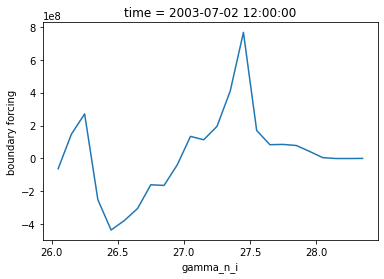

In [13]:
G['heat']['boundary forcing'].isel(time=0).plot()